In [132]:

!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1sq9TGMcpnig3sj4uG-dJOTmf_Q-H4a2s/view?usp=share_link'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('final_table.csv') 
 
df = pd.read_csv('final_table.csv')
print(df)

In [1]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np




import pandas as pd
import sys

from config import *




from utils import test_agent, plot_stats, seed_everything
from utils import test_policy_network, test_agent, plot_max_q, seed_everything, plot_stats, plot_cost_to_go
from parallel_env import ParallelEnv, ParallelWrapper
%matplotlib notebook


In [149]:
class AdaptiveRobotEnvironment(gym.Env):
    
    
    """An environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}  
    def __init__(self,  data_path):
        super(AdaptiveRobotEnvironment, self).__init__()
        
        self.df = pd.read_csv(data_path)
        self.df.dropna(inplace=True)
        
        
        # Create a dictionary with sessionID as key and childIDs as values
        self.session_child_spaces = {}
        self.session_ids = self.df.sessionID.unique()
        
        for session_id in self.session_ids:
            session_df = self.df[self.df['sessionID'] == session_id]
            self.child_action_spaces = {}
            self.child_ids = self.df.childID.unique()
            i =0
            for child_id in self.child_ids:
                child_df = session_df[session_df['childID']==child_id]
                if child_df.appID.unique().shape[0] == 0:
                    continue
                else:
                    self.child_action_spaces[child_id] = (i,child_df.appID.unique())
                    self.child_action_spaces[child_id][1].sort()
                    i+=1
                    
            self.session_child_spaces[session_id] = self.child_action_spaces
            #self.session_child_spaces[session_id].sort()
        
        
        
        # initialise state:
        self.state = self.df.loc[self.df['frameID']==0].sample(1)
        self.current_sessionID = self.state['sessionID'].values[0]
        self.current_childID = self.state['childID'].values[0]
        self.current_appID = self.state['appID'].values[0]
        self.frameID = self.state['frameID'].values[0]
        
        self.current_childIndex = self.session_child_spaces[self.current_sessionID][self.current_childID][0]
        self.current_appIndex = np.where(self.session_child_spaces[self.current_sessionID][self.current_childID][1] == self.current_appID)[0][0]
        
        
        self.un_action = {}
        child_ids = self.df.childID.unique()
        for child_id in child_ids:
            child_df = self.df[self.df['childID'] == child_id]
            self.un_action[child_id] = child_df.appID.unique()
        
        # initialise action space
        self.action_space = self.session_child_spaces[self.current_sessionID][self.current_childID][1]
        self.action_space.sort()
        self.action = None
        
        # initialize the table of completed actions 
        self.completed_acts = [0]*self.action_space.shape[0]
        self.completed_acts[self.current_appIndex] = 1
        
        
        # initialise a table of completed children
        self.completed_ch = [0]*len(self.session_child_spaces[self.current_sessionID])
        self.completed_ch[self.current_childIndex] = 1
        
        
        self.state = (np.asarray(self.state))[0]
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.state.shape, dtype=np.float16)
        self.reward = []
        self.counter = 0

        
    def calculate_reward(self, old_state, next_state):
        
        """com_action = 10*(1  - sum(self.completed_acts)/len(self.completed_acts))
        
        engagement = old_state['engagement_x'].values[0]
        #print(f"Engagement: {engagement}")
        
        
        time_reward = 10*(1-self.counter/300)
        
        #print(f"Time reward: {time_reward}")
        if self.counter == 300:
            self.counter = 0
        
        reward = -1*time_reward*((5-engagement)+com_action)
        """
        
        engagement_old = old_state['engagement_x'].values[0]
        engagement_new = next_state['engagement_x'].values[0]

        time_reward = 10 * (1 - self.counter / 300)

        engagement_diff = engagement_old-engagement_new
        engagement_reward = max(engagement_diff, 0) * (-1)

        app_diversity_bonus = 0
        if self.action != self.action_space[action]:
            app_diversity_bonus = 2

        child_completion_bonus = 0
        if sum(self.completed_ch) / len(self.completed_ch) == 1:
            child_completion_bonus = 10

        reward = (engagement_reward + (time_reward + app_diversity_bonus + child_completion_bonus))

        return reward
        
    
    
    def change_action(self):
        pass
        
    def make_action(self, action):
        self.action_space = self.session_child_spaces[self.current_sessionID][self.current_childID][1]
        
        
        
        
        if self.action != self.action_space[action]:
                    
            self.state = self.df
            
            
            self.state = self.state.loc[self.state['sessionID']==self.current_sessionID].loc[self.state['childID']==self.current_childID].loc[self.state['appID'] == self.action_space[action]].loc[self.state['frameID']==0]
            
            self.current_childID = self.state['childID'].values[0]
            self.current_sessionID= self.state['sessionID'].values[0]
            
            
            self.current_appID = self.state['appID'].values[0]
            self.current_appIndex = np.where(self.session_child_spaces[self.current_sessionID][self.current_childID][1] == self.current_appID)[0][0]
            
            self.completed_acts[self.current_appIndex] = 1
            
                        
            self.action = self.action_space[action]
           
            return self.state
            
            
            
        
        
        
        
        new_state = self.df.loc[self.df['sessionID']==self.current_sessionID].loc[self.df['childID']==self.current_childID].loc[self.df['appID']==self.action]
            
        frames = new_state.frameID.unique()
        frames.sort()
            
        index = np.where(frames == self.state['frameID'].values[0])[0][0]
               
        
        if index == len(self.df.loc[self.df['sessionID']==self.current_sessionID].loc[self.df['childID']==self.current_childID].loc[self.df['appID']==self.action].index)-1:
            
            self.state = self.df
            #print(f"The completed table: {self.completed}")
            
            self.state = self.state.loc[self.state['sessionID']==self.current_sessionID].loc[self.state['childID']==self.current_childID].loc[self.state['appID'] == self.action_space[action]].loc[self.state['frameID']==0]
            #print(f"Child is not changed. OLD: {self.current_childID}, New: {self.state['childID'].values[0]}")
            #print()
            self.current_childID = self.state['childID'].values[0]
            
            
            self.current_appID = self.state['appID'].values[0]
            self.current_appIndex = np.where(self.session_child_spaces[self.current_sessionID][self.current_childID][1] == self.current_appID)[0][0]
            
            self.completed_acts[self.current_appIndex] = 1
            
                        
            self.action = self.action_space[action]
           
            return self.state
        
        
        next_state = new_state.loc[new_state['frameID']==frames[index+1]]
        self.state =  next_state
                        
        return next_state
    
    
    def print_data(self, action, data_type):
        
        if data_type == 'old':
            print(f"Current session: {self.current_sessionID}")
            print(f"Current child: {self.current_childID}")
            print(f"Child completed table: {self.completed_ch}")

            print(f"Current action: {self.current_appID}")
            print(f"Old action index: {self.action}")
            print(f"New action index {action}")
            print(f"Current action_space: {self.action_space}")
            print(f"Action completed table: {self.completed_acts}")
        elif data_type == 'new':
            print("-"*20)
            print(f"New current session: {self.current_sessionID}")
            print(f"New current child: {self.current_childID}")
            print(f"New child completed table: {self.completed_ch}")


            print(f"New current action_space: {self.action_space}")
            print(f"New action completed table: {self.completed_acts}")
            
            
        
        

    def step(self, action):
        done = False
        info = None 
        reward = None
        self.counter += 1
        
        
        #self.print_data(action, 'old')

        old_state = self.state
        next_state = self.make_action(action)
        reward = self.calculate_reward(old_state, next_state)
        
        """next_state = self.make_action(action)
        reward = self.calculate_reward(next_state)"""
        
        next_state = (np.asarray(next_state))[0]
        
        if reward == 0.0:
            done = True
            
            
        if sum(self.completed_acts)/len(self.completed_acts) == 1:
            
            if sum(self.completed_ch)/len(self.completed_ch) == 1:
                self.state = self.df
                self.state = self.state.loc[self.state['frameID']==0].sample(1)
                self.current_sessionID = self.state['sessionID'].values[0]
                
                self.completed_ch = [0]*len(self.session_child_spaces[self.current_sessionID])
            else:              
                self.state = self.df.loc[self.df['sessionID'] == self.current_sessionID]
                self.state = self.state.loc[self.state['frameID']==0].sample(1)
                
            
            self.current_childID = self.state['childID'].values[0]
            self.current_appID = self.state['appID'].values[0]
            self.frameID = self.state['frameID'].values[0]
            
            
            self.current_childIndex = self.session_child_spaces[self.current_sessionID][self.current_childID][0]
            self.completed_ch[self.current_childIndex] = 1
            
            
            
            self.action_space = self.session_child_spaces[self.current_sessionID][self.current_childID][1]
            self.completed_acts = [0]*self.action_space.shape[0]
            self.current_appIndex = np.where(self.session_child_spaces[self.current_sessionID][self.current_childID][1] == self.current_appID)[0][0]
            self.completed_acts[self.current_appIndex] = 1
        
        
        #self.print_data(action, 'new')
        #print()
        
            
            
            
        
        return next_state, reward, done, _
            
        
    
    def reset(self):
        
        self.state = self.df.loc[self.df['frameID']==0].sample(1)
        self.childID = self.state['childID'].values[0]
        self.sessionID = self.state['sessionID'].values[0]
        self.frameID = self.state['frameID'].values[0]
        
        state_return = (np.asarray(self.state))[0]       
        return state_return
    
    def render(self, mode, close):
        if mode == 'train':
            self.state = [self.df.sample(1), self.autism_level, self.hyperactivity, self.fluency, self.age]
        else:
            return None
            
        
    

In [150]:
data_path = 'final_table.csv'
env = AdaptiveRobotEnvironment(data_path)

In [151]:
state = env.reset()

state_dims = env.observation_space.shape[0]
#print(f"CartPole env: State dimentions {state_dims}, Number of actions: {num_actions}")

In [121]:



action = 1
for i in range(1000000):
    actions = np.arange(env.session_child_spaces[env.current_sessionID][env.current_childID][1].shape[0])
    #print(f"current child: {env.current_childID}")
    action = random.choice(actions)
    #action = 1
    #print(action)
    next_state, reward, done, _ = env.step(action)
    print(reward)
    print()
print("Sample state:")



-0.0

-0.0

-0.0

-49.333333333333336

-98.33333333333331

-49.0

-0.0

-0.0

-0.0

-145.0

-0.0

-48.0

-0.0

-0.0

-0.0

-0.0

-188.66666666666669

-0.0

-0.0

-0.0

-0.0

-0.0

-0.0

-0.0

-183.33333333333331

-91.33333333333333

-0.0

-0.0

-90.33333333333333

-0.0

-0.0

-89.33333333333334

-0.0

-88.66666666666667

-0.0

-44.0

-0.0

-0.0

-0.0

-43.33333333333334

-0.0

-0.0

-0.0

-0.0

-42.5

-0.0

-0.0

-0.0

-83.66666666666667

-0.0

-0.0

-0.0

-0.0

-0.0

-40.83333333333333

-0.0

-0.0

-0.0

-0.0

-0.0

-39.833333333333336

-0.0

-0.0

-0.0

-0.0

-39.0

-0.0

-0.0

-0.0

-0.0

-0.0

-0.0

-37.83333333333333

-0.0

-0.0

-0.0

-0.0

-37.0

-0.0

-36.66666666666667

-0.0

-72.66666666666667

-0.0

-0.0

-0.0

-107.0

-0.0

-35.33333333333333

-0.0

-0.0

-0.0

-0.0

-34.5

-0.0

-136.66666666666669

-0.0

-0.0

-0.0

-0.0

-33.33333333333334

-0.0

-0.0

-0.0

-0.0

-130.0

-0.0

-0.0

-128.0

-0.0

-0.0

-126.0

-0.0

-62.33333333333333

-31.0

-0.0

-30.666666666666664



KeyboardInterrupt: 

In [152]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        
        
        self.session_child_spaces = env.session_child_spaces
        self.current_childID = env.current_childID
        self.current_sessionID = env.current_sessionID
        self.completed_acts = env.completed_acts
        self.completed_ch = env.completed_ch
    
    def reset(self):
        obs = self.env.reset()
        
        
        
        #print(f"OBS shape: {obs[0][0]}")
        #print(np.asarray(obs))
        return torch.from_numpy(obs[3:415]).unsqueeze(dim=0).float()
    
    def step(self, action):
        
        
        action = action.item()
        
        next_state, reward, done, info = self.env.step(action)
        
        next_state = torch.from_numpy(next_state[3:415]).unsqueeze(dim=0).float()
        
        self.current_childID = env.current_childID
        self.current_sessionID = env.current_sessionID
        self.completed_acts = env.completed_acts
        self.completed_ch = env.completed_ch
        
        state_min, _ = torch.min(next_state, dim=1, keepdim=True)
        state_max, _ = torch.max(next_state, dim=1, keepdim=True)
        next_state = (next_state - state_min) / (state_max - state_min)
        
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [153]:
env1 = PreprocessEnv(env)

In [154]:
state = env1.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env1.step(action)
#print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Next state: tensor([[0.6462, 0.3031, 0.0341, 0.8504, 0.4039, 0.0337, 0.7578, 0.4311, 0.0336,
         0.5918, 0.6244, 0.0338, 0.2433, 0.6980, 0.0336, 0.9374, 0.3794, 0.0336,
         0.7414, 0.7061, 0.0335, 0.4093, 0.7795, 0.0333, 0.9238, 0.8531, 0.0335,
         0.8476, 0.8149, 0.0333, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332,
         1.0000, 0.9075, 0.0335, 0.5890, 0.8068, 0.0333, 0.0332, 0.0332, 0.0332,
         0.6326, 0.2623, 0.0334, 0.6706, 0.2406, 0.0341, 0.0332, 0.0332, 0.0332,
         0.8095, 0.2133, 0.0341, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332,
         0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332,
         0.0332, 0.0332, 0.0332, 0.3450, 0.7921, 0.0337, 0.2629, 0.7787, 0.0337,
         0.1959, 0.7669, 0.0338, 0.1523, 0.7803, 0.0336, 0.1204, 0.7854, 0.0334,
         0.1623, 0.7753, 0.0341, 0.0970, 0.8088, 0.0340, 0.1070, 0.8105, 0.0339,
         0.1338, 0.8071, 0.0338, 0.1757, 0.8122, 0.0342, 0.1087, 0.8423, 0.0341,
         0.1322,

In [155]:
max_num_actions = 8
q_network = nn.Sequential(
            nn.Linear(412, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, max_num_actions))


In [156]:
target_q_network = copy.deepcopy(q_network).eval() 

In [157]:
import sys

In [158]:
def policy(state, epsilon, valid_actions):
    if np.random.rand() < epsilon:
        #print()
        valid_actions_tensor = torch.tensor(valid_actions, dtype=torch.long)
        
        valid_actions_mask = torch.zeros(1,8) - float('inf')
        #print(f"Valid actions mask: {valid_actions_mask}")
        valid_actions_mask[0, valid_actions_tensor] = 0
        
        
        valid_actions_mask_1 = torch.zeros(1,8)
        valid_actions_mask_1[0, valid_actions_tensor] = 1

        
        action_value = np.random.choice(valid_actions, size=1)
        #print(f"action: {action_value}")
        
        
        action_index = np.where(valid_actions == action_value[0])[0]
        #print()
        
        
        return torch.from_numpy(np.array([action_value])), torch.from_numpy(np.array([action_index])), valid_actions_mask_1
    else:
        
        valid_actions_tensor = torch.tensor(valid_actions, dtype=torch.long)
        #print(f"Valid actions tensor: {valid_actions_tensor}")
        
        
        
        av = q_network(state).detach()
        
        
        
        
        
        valid_actions_mask = torch.zeros_like(av) - float('inf')
        #print(f"Valid actions masks 1: {valid_actions_mask}")
        valid_actions_mask[0, valid_actions_tensor] = 0

        masked_q_values = av + valid_actions_mask
        
        
        valid_actions_mask_1 = torch.zeros_like(av)
        valid_actions_mask_1[0, valid_actions_tensor] = 1
        
        
        
        
        """print(f"Valid actions masks: {valid_actions_mask}")
        
        print(f"AV: {av}, AV SHAPE: {av.shape}")
        print(f"Masked Q Values: {masked_q_values}, AV SHAPE: {masked_q_values.shape}")"""
        action_value = torch.argmax(masked_q_values, dim=-1, keepdim=True)
        #print(f"action: {action_value.numpy()}")
        
        action_index = np.where(valid_actions == action_value.numpy()[0][0])[0]
        """print(f"action index array {action_index}")
        print(f"Action index: {torch.from_numpy(np.array([action_index]))}")
        print()
        print()"""
        return action_value, torch.from_numpy(np.array([action_index])), valid_actions_mask_1

In [159]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        #print(f"In transition: {transition}")
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        #print(batch.size)
        batch = zip(*batch)
        """for items in zip(*batch):
            print([item.shape for item in items])"""
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [160]:
def deep_q_learning(q_network, episodes, alpha=0.000001, batch_size=64, gamma=0.99, epsilon=0.2):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory(capacity=1000000)
    stats = {'MSE Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = env1.reset()
        done = False
        ep_return = 0.

        while not done:
            #q_values = q_network(state)
            
            valid_actions = env1.session_child_spaces[env1.current_sessionID][env1.current_childID][1]
            
            action_value, action, valid_actions_mask = policy(state, epsilon, valid_actions)
            
            
            
            
            
            
            
            #print(f"that twisted action: {action}")

            next_state, reward, done, _ = env1.step(action)
            memory.insert((state, action, action_value, valid_actions_mask, reward, done, next_state))

            if memory.can_sample(batch_size):
                #print("FUCKED UP")
                state_b, action_b, action_value_b, valid_actions_mask_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                
                
                #print(f"Without gather {q_network(state_b)}")
                #print(f" Action b: {action_value_b}")
                              
                qsa_b = q_network(state_b).gather(1, action_value_b)
                
                
                
                
                
                
                #print(f"Q value: {qsa_b}")
                
                
                next_qsa_b = target_q_network(next_state_b)
                
                #print(f"Next Q value: {next_qsa_b}")
                
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                
                #print(f"Next Q value after max: {next_qsa_b}")
                
                

                target_b = reward_b + ~done_b * gamma * next_qsa_b
                
                #print(f"Target b: {target_b}")

                loss = F.mse_loss(qsa_b, target_b, reduction='none')
                #print(f"Loss: {loss}")
                #print(f"Valid actions mask: {valid_actions_mask}")
                masked_loss = (loss * valid_actions_mask_b).sum() / valid_actions_mask_b.sum()
                
                #print(f"Masked loss: {masked_loss}")

                q_network.zero_grad()
                masked_loss.backward()
                optim.step()

                stats['MSE Loss'].append(masked_loss.item())

            state = next_state
            ep_return += reward.item()

        stats['Returns'].append(ep_return)

        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats


In [161]:
stats = deep_q_learning(q_network, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


<IPython.core.display.Javascript object>


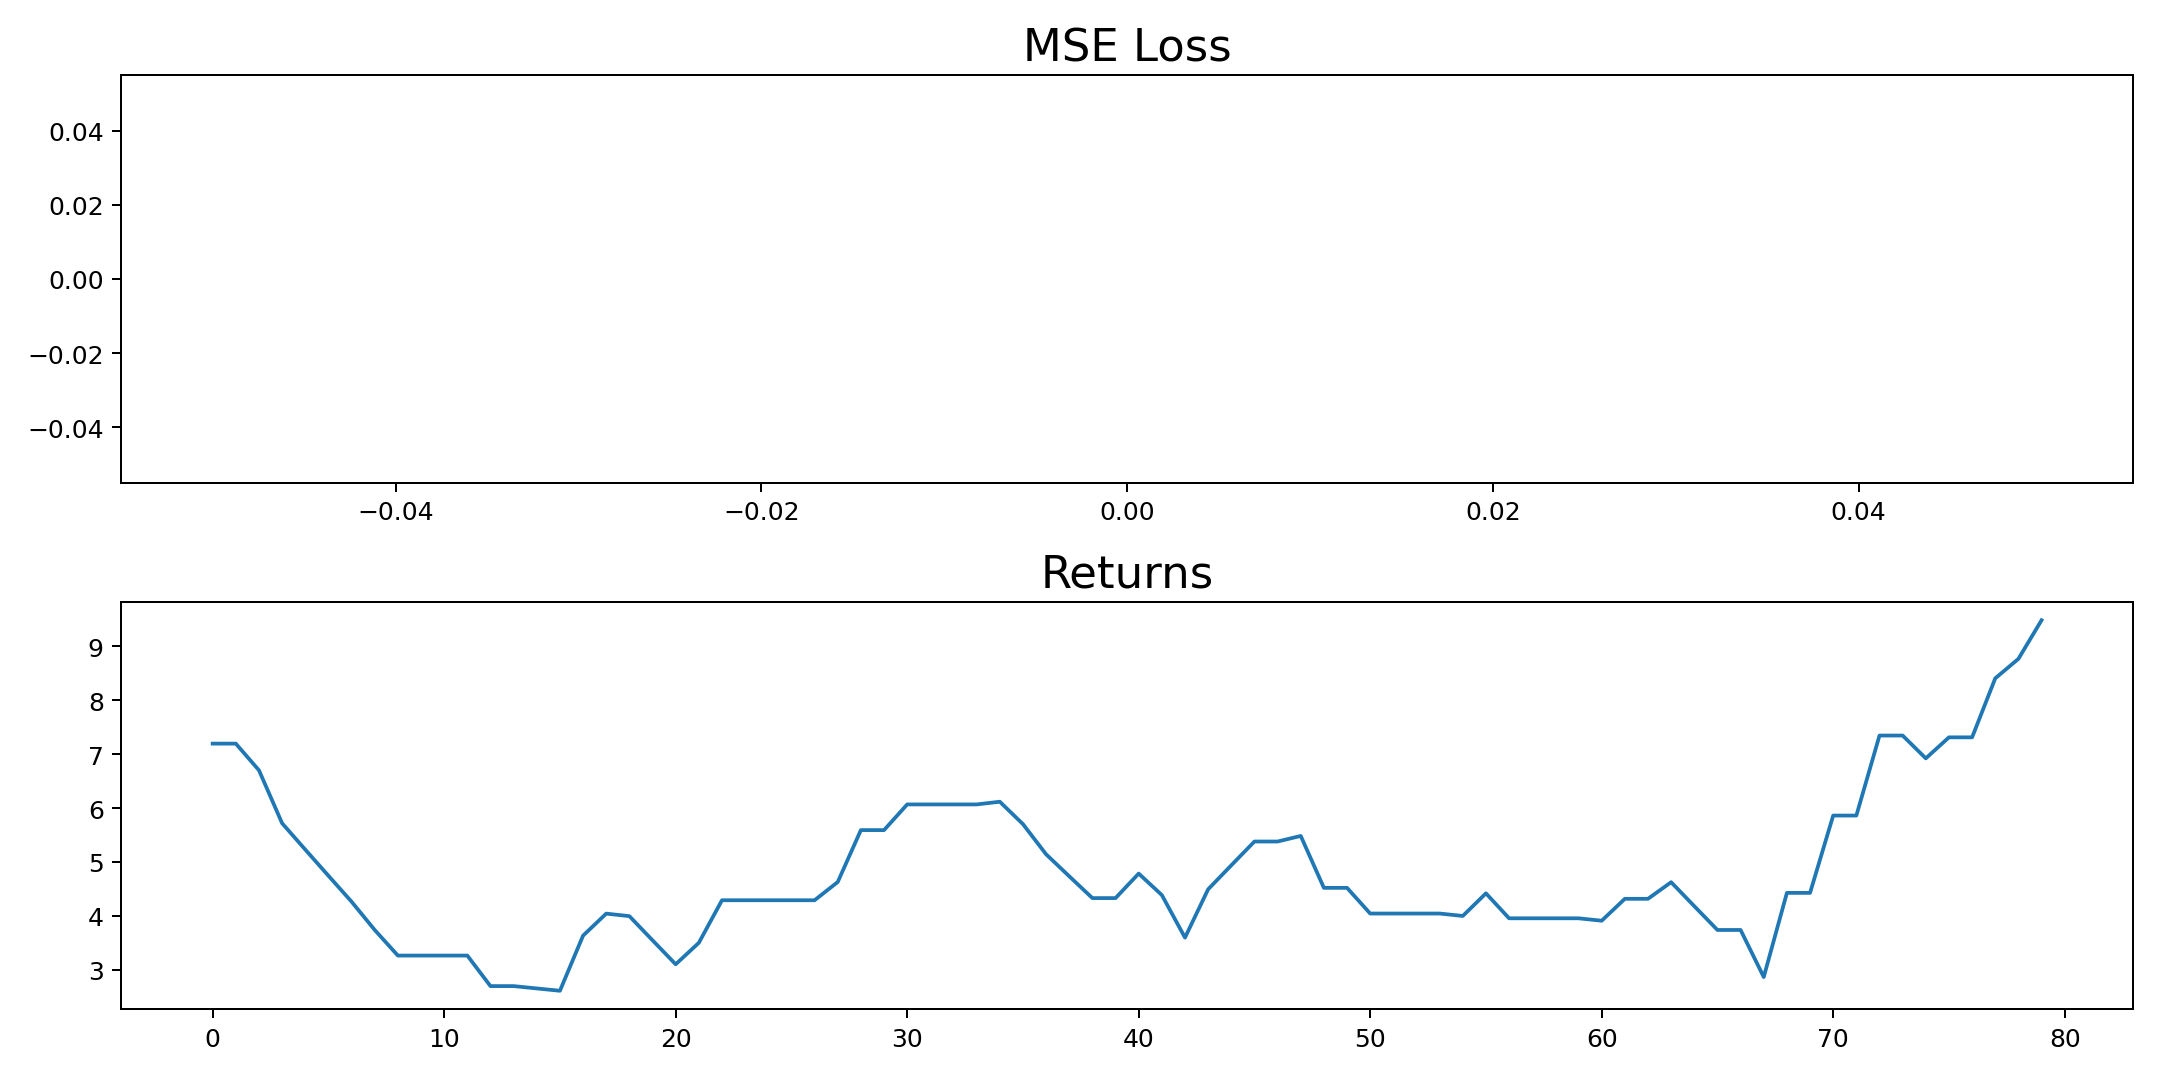

In [162]:
plot_stats(stats)